# End to End Pipeline
---
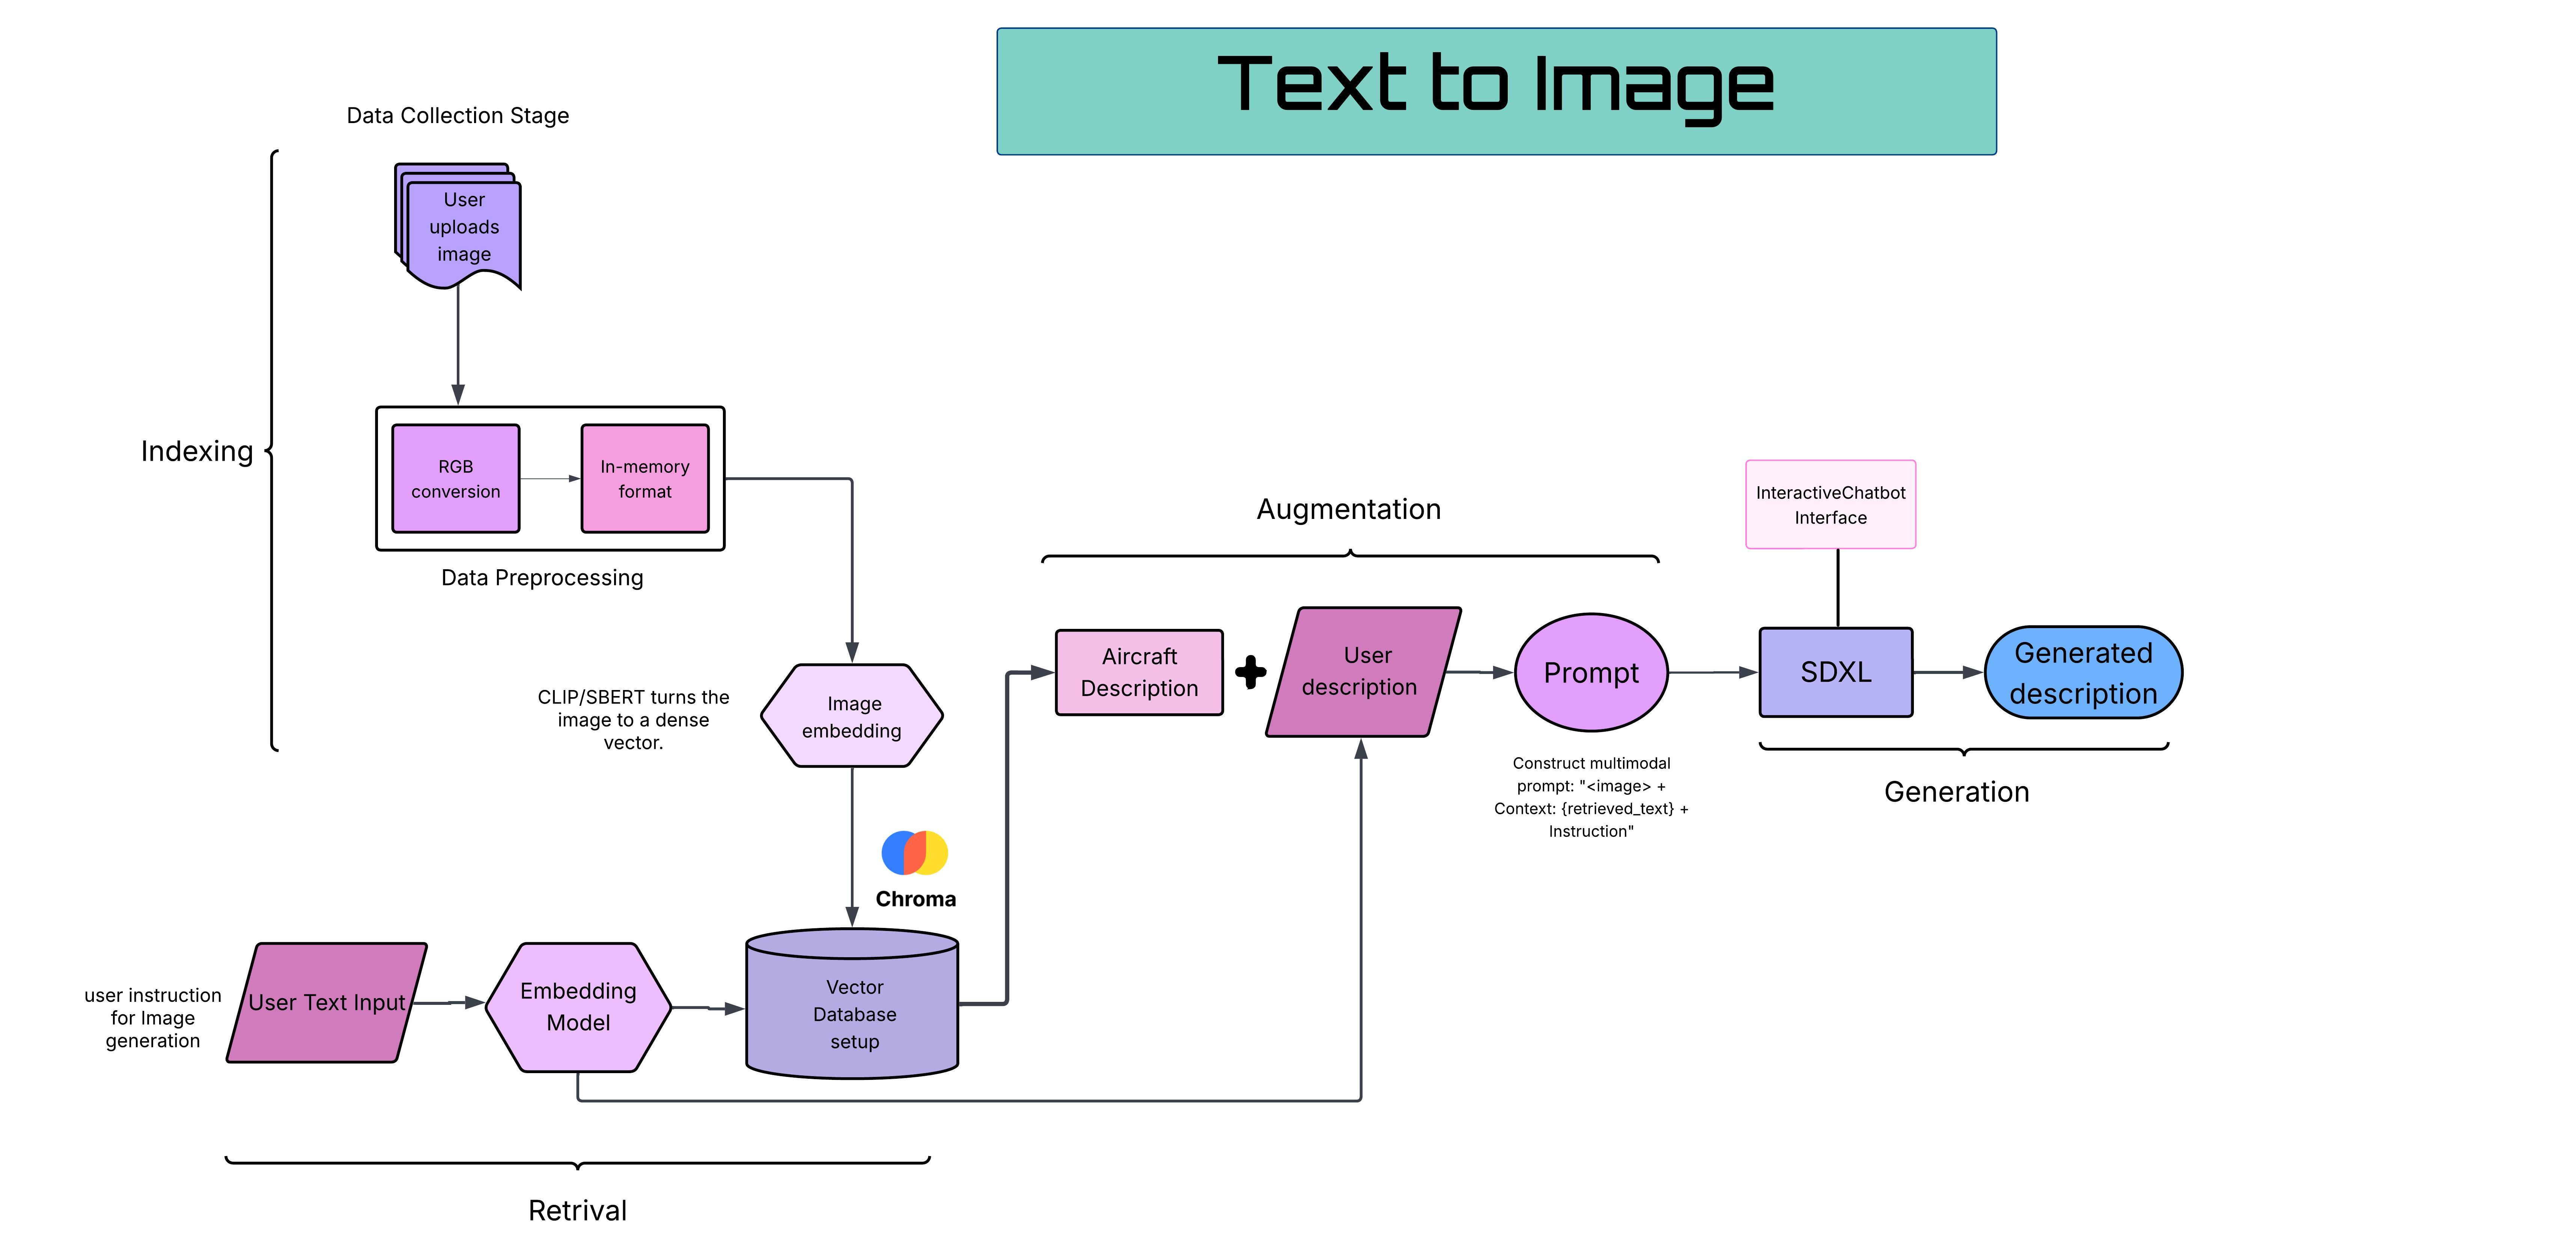

---

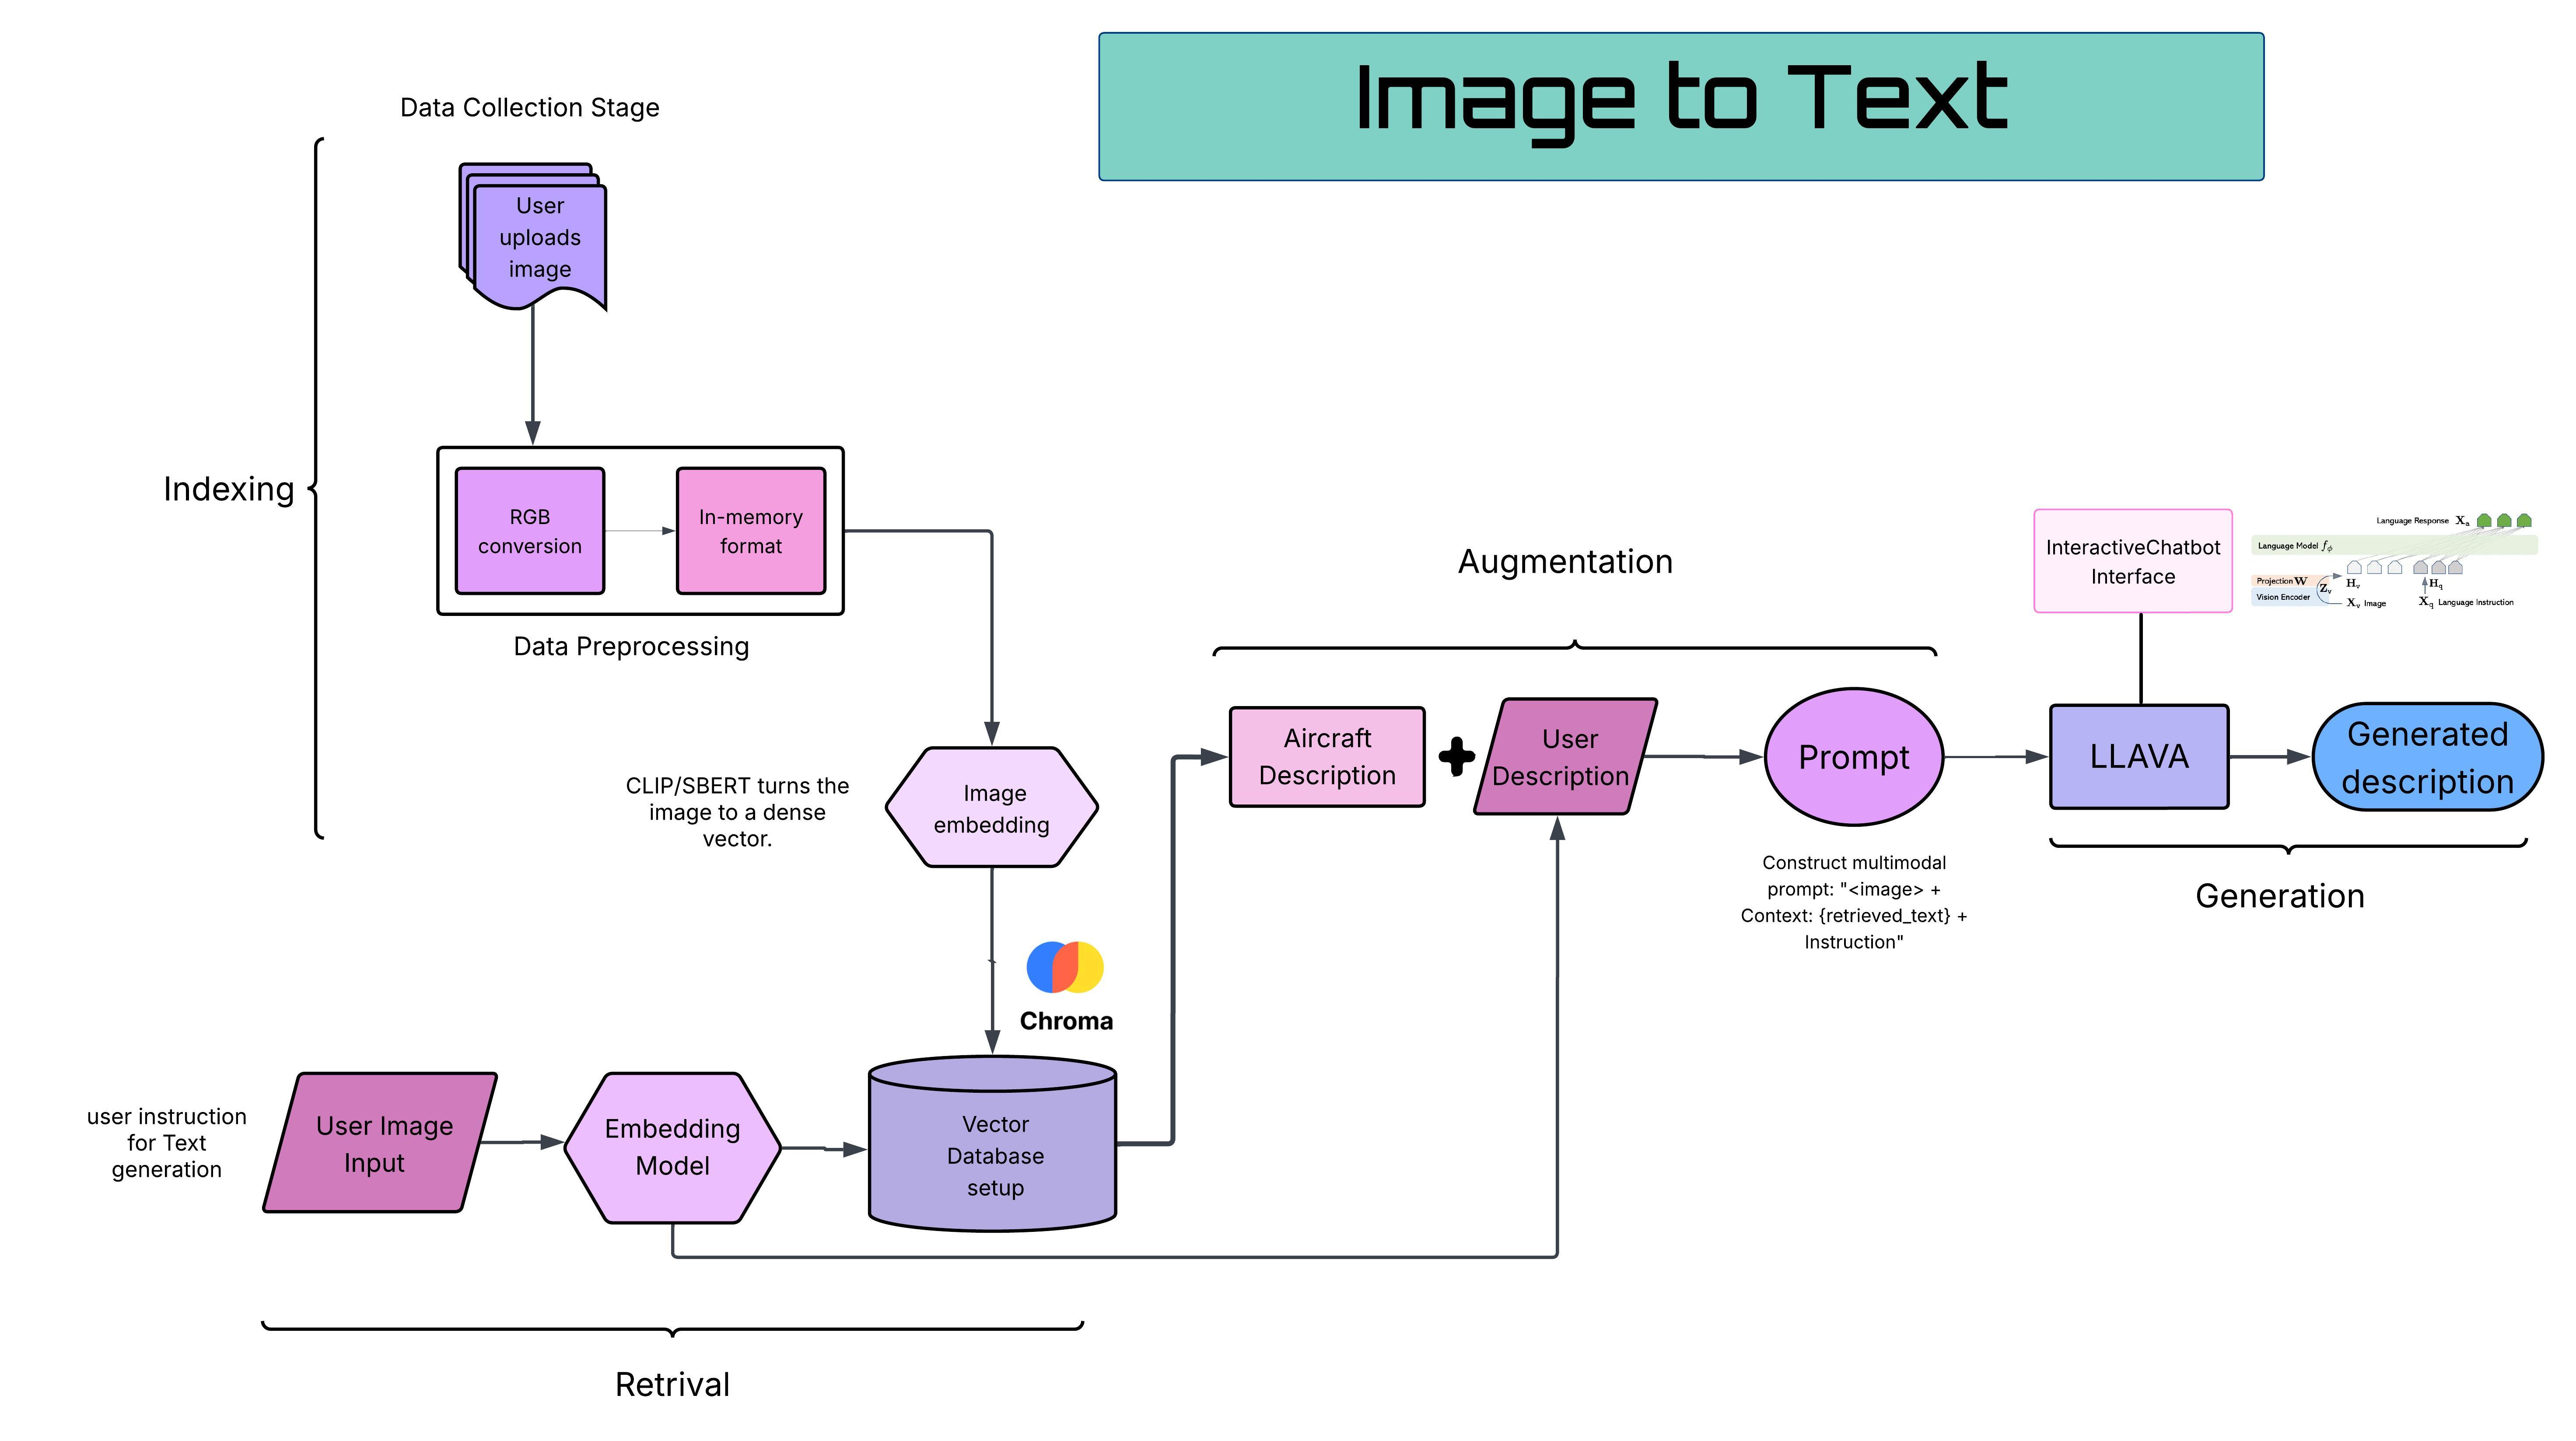


#Setup and Finetuning

###
Imports and high-level setup

This cell imports the Python libraries that the rest of the notebook uses.

- os: filesystem operations (checking paths, creating folders).
- streamlit: frontend framework used to build the web UI (app.py).
- google.colab.drive: helper to mount Google Drive into the Colab VM so we can read model files or datasets stored in Drive.
- google.colab.userdata: (optional) helper for reading notebook secrets (used later for ngrok token).
- pyngrok.ngrok: utility to create a public tunnel from the Colab VM to the internet (used to expose Streamlit).

Why these imports are grouped here:
- We import Colab-specific helpers early so mounting and secret retrieval are done at startup.
- pyngrok is only used when creating a public URL for the Streamlit app.

- Mount the user's Google Drive at /content/drive so the notebook can read model checkpoints, adapters, or any other files stored in Drive.

Behavior:
- drive.mount('/content/drive') will prompt the user to authorize access the first time it runs.
- If Drive is already mounted, Colab prints a notice. To re-mount forcibly, call drive.mount(..., force_remount=True).

Why we mount:
- Later we look for a folder named Aircraft_Model_Sleep in /content or inside Drive; mounting makes Drive files accessible.




In [ ]:
# ==========================================
# PART 1: SETUP & INSTALLATION
# ==========================================
import os
import json
import re
import random
import glob
from google.colab import drive
import shutil
import subprocess
import torch
import gc
import sys
from pyngrok import ngrok
from google.colab import userdata

# 1. Mount Drive & Install LLaMA-Factory
drive.mount('/content/drive')
!git clone https://github.com/hiyouga/LLaMA-Factory.git
!pip install -q -r LLaMA-Factory/requirements.txt
!pip install -q bitsandbytes

Mounted at /content/drive
Cloning into 'LLaMA-Factory'...
remote: Enumerating objects: 24605, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 24605 (delta 67), reused 24 (delta 24), pack-reused 24475 (from 2)
Receiving objects: 100% (24605/24605), 12.21 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (17692/17692), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# ==========================================
# PART 2: PREPARE DATASET
# ==========================================

# 2. Unzip Images
zip_path = "/content/drive/MyDrive/aircraft_images.zip"
extract_path = "/content/aircraft_dataset"

if not os.path.exists(extract_path):
    print("Unzipping images... (This may take a minute)")
    !unzip -q "{zip_path}" -d "{extract_path}"
    print("Unzipped")

📂 Unzipping images... (This may take a minute)
unzip:  cannot find or open /content/drive/MyDrive/aircraft_images.zip, /content/drive/MyDrive/aircraft_images.zip.zip or /content/drive/MyDrive/aircraft_images.zip.ZIP.
✅ Unzipped


Verify model folder exists

Purpose:
- Quickly check a few expected locations for a saved model/adapter directory and set the variable adapter_root to the first match.

What it does:
- possible_paths: list of candidate paths where the model/adapters might be stored (for convenience we check multiple possibilities).
- The loop tests each path with os.path.exists; if a path is found, adapter_root is set to that path and we print a confirmation.

Why:
- Later the Streamlit app will try to load a PEFT adapter from adapter_root. This check prevents hard-coded paths from causing errors and allows the notebook to
  gracefully handle a missing model by switching to "base model only" mode.

If adapter_root remains None:
- We set adapter_root to the string "MISSING" and the app will know the adapter is not available.



In [ ]:
# 1. Define the path to your external JSON file
# (Update this path if you move the file later)
json_file_path = "/content/drive/MyDrive/aircraft_descriptions.json"

# 2. Load the JSON directly into the variable
print(f"Loading descriptions from: {json_file_path}...")

try:
    with open(json_file_path, 'r') as f:
        aircraft_descriptions = json.load(f)
    print(f"Successfully loaded {len(aircraft_descriptions)} aircraft descriptions.")

except FileNotFoundError:
    print(f"ERROR: Could not find file at {json_file_path}")
    print("Make sure you uploaded 'aircraft_descriptions.json' to the Colab Files tab!")
    # Create an empty dict so the code doesn't crash later
    aircraft_descriptions = {}

Loading descriptions from: /content/drive/MyDrive/aircraft_descriptions.json...
Successfully loaded 43 aircraft descriptions.


In [ ]:
# 1. FIND THE IMAGES AUTOMATICALLY
# We look for a folder that contains "A10" or "A-10" to locate the root
base_path = "/content/aircraft_dataset"
found_root = None

print("Hunting for image folders...")

for root, dirs, files in os.walk(base_path):
    # Check if this folder contains aircraft folders (e.g., 'A10', 'B52')
    # We check for a few common ones to be sure
    if "A10" in dirs or "F16" in dirs or "A-10" in dirs:
        found_root = root
        print(f"FOUND images in: {found_root}")
        break

if not found_root:
    # If we still can't find it, print the directory structure to debug
    print("Could not find aircraft folders. Here is what exists:")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        # Print first 2 files only to save space
        for f in files[:2]:
            print(f"{subindent}{f}")
    raise FileNotFoundError("Please check the structure printed above.")

# 2. RERUN THE GENERATION WITH THE CORRECT PATH
image_dir = found_root
training_data = []
found_count = 0

print(f"\nRestarting generation using: {image_dir}")

# (Re-paste the descriptions dict just to be safe it's in memory)
# ... [I assume the 'aircraft_descriptions' variable is still in memory from the previous cell]
# If you get a 'NameError', please re-run the previous cell's "Part 3" section!

if 'aircraft_descriptions' not in globals():
    print("'aircraft_descriptions' is missing! Please re-run the BIG code block from Part 3 (Define Descriptions) first.")
else:
    for plane_name, description in aircraft_descriptions.items():
        # Clean name logic
        clean_name = re.sub(r'[^a-zA-Z0-9]', '', plane_name)

        # Folder matching logic
        if plane_name == "F/A-18": target_folder = "F18"
        elif plane_name == "P-3": target_folder = "P3"
        else: target_folder = clean_name

        folder_path = os.path.join(image_dir, target_folder)

        # Fallback search
        if not os.path.exists(folder_path):
            candidates = [d for d in os.listdir(image_dir) if clean_name in d or target_folder in d]
            if candidates:
                folder_path = os.path.join(image_dir, candidates[0])

        if os.path.exists(folder_path):
            images = glob.glob(os.path.join(folder_path, "*"))
            if len(images) > 0:
                found_count += 1
                selected_images = random.sample(images, min(len(images), 20))

                for img_path in selected_images:
                    entry = {
                        "image": [img_path],
                        "messages": [
                            {"content": "<image>Describe this aircraft and its distinguishing features.", "role": "user"},
                            {"content": f"This is a {plane_name}. {description}", "role": "assistant"}
                        ]
                    }
                    training_data.append(entry)
        else:
             # Silent fail to keep output clean, but you can uncomment to see misses
             # print(f"  - Missed: {plane_name}")
             pass

    # 3. SAVE AND FINISH
    output_file = "/content/LLaMA-Factory/data/aircraft_train.json"
    with open(output_file, "w") as f:
        json.dump(training_data, f, indent=2)

    print(f"\nSUCCESS! Created dataset with {len(training_data)} examples covering {found_count} aircraft types.")

    # 4. REGISTER (Again, just to be sure)
    info_path = "/content/LLaMA-Factory/data/dataset_info.json"
    with open(info_path, "r") as f:
        dataset_info = json.load(f)

    dataset_info["aircraft_demo"] = {
        "file_name": "aircraft_train.json",
        "formatting": "sharegpt",
        "columns": {"messages": "messages", "images": "image"},
        "tags": {"role_tag": False, "b_tag": False, "i_tag": False}
    }

    with open(info_path, "w") as f:
        json.dump(dataset_info, f, indent=2)
    print("Dataset registered.")

In [ ]:
# 5. Save the train.json
output_file = "/content/LLaMA-Factory/data/aircraft_train.json"
with open(output_file, "w") as f:
    json.dump(training_data, f, indent=2)

print(f"\nCreated dataset with {len(training_data)} examples covering {found_count} aircraft types.")

# 6. Register the dataset in LLaMA-Factory
# We append our new dataset to the dataset_info.json file
info_path = "/content/LLaMA-Factory/data/dataset_info.json"
with open(info_path, "r") as f:
    dataset_info = json.load(f)

dataset_info["aircraft_demo"] = {
    "file_name": "aircraft_train.json",
    "formatting": "sharegpt",
    "columns": {
        "messages": "messages",
        "images": "image"
    },
    "tags": {
        "role_tag": False,
        "b_tag": False,
        "i_tag": False
    }
}

with open(info_path, "w") as f:
    json.dump(dataset_info, f, indent=2)

print("Registered 'aircraft_demo' in dataset_info.json")

In [ ]:
# 1. READ THE OLD DATA
old_file = "/content/LLaMA-Factory/data/aircraft_train.json"
print(f"Fixing dataset format in {old_file}...")

with open(old_file, "r") as f:
    old_data = json.load(f)

# 2. CONVERT TO STANDARD SHAREGPT FORMAT
# New Format: "conversations": [{"from": "human", "value": "..."}], "images": [...]
new_data = []

for entry in old_data:
    # 1. Get images
    # Old: "image": ["path"] -> New: "images": ["path"]
    images = entry.get("image", [])

    # 2. Convert messages
    # Old: "role": "user"/"assistant", "content": "..."
    # New: "from": "human"/"gpt", "value": "..."
    new_convs = []
    for msg in entry["messages"]:
        role = "human" if msg["role"] == "user" else "gpt"
        content = msg["content"]
        new_convs.append({
            "from": role,
            "value": content
        })

    new_entry = {
        "conversations": new_convs,
        "images": images
    }
    new_data.append(new_entry)

# 3. OVERWRITE THE TRAIN FILE
with open(old_file, "w") as f:
    json.dump(new_data, f, indent=2)

print(f"Converted {len(new_data)} items to ShareGPT format.")

# 4. FIX DATASET_INFO.JSON (Remove the 'tags' block that caused the error)
info_path = "/content/LLaMA-Factory/data/dataset_info.json"
with open(info_path, "r") as f:
    info = json.load(f)

info["aircraft_demo"] = {
    "file_name": "aircraft_train.json",
    "formatting": "sharegpt",
    "columns": {
        "messages": "conversations", # Map to our new 'conversations' key
        "images": "images"           # Map to our new 'images' key
    }
    # REMOVED "tags": {...} entirely to let LLaMA-Factory use defaults
}

with open(info_path, "w") as f:
    json.dump(info, f, indent=2)

print("Fixed dataset_info.json. You are ready to train!")

### Install Python dependencies

Purpose:
- Install the exact versions of libraries that the app expects. Pinning versions reduces compatibility issues between transformers, diffusers, bitsandbytes, and peft.

What it installs:
- streamlit: UI framework
- pyngrok: to expose the app publicly from Colab
- chromadb: vector DB for RAG
- sentence-transformers: CLIP-based embedding model
- accelerate, bitsandbytes, diffusers, transformers, huggingface-hub, peft: model runtime and quantization stack

Why pinned versions:
- Some model loading and quantization flows require specific library versions (for example bitsandbytes + Transformers compatibility).
- Using pinned versions increases reproducibility and reduces runtime errors on different Colab runtimes.

Note:
- This cell runs pip install commands in the notebook runtime (Colab). It may take a few minutes and may require a GPU-compatible runtime for full functionality.

In [ ]:
%cd /content/LLaMA-Factory

# 1. Install LLaMA-Factory in 'editable' mode (This creates the CLI command)
print("Installing LLaMA-Factory CLI...")
!pip install -e .

# 2. Install Gradio for the UI
!pip install -q gradio

# 3. Launch the Web UI
print("Launching Web UI... Click the public link when it appears!")
!GRADIO_SHARE=1 llamafactory-cli webui

/content/LLaMA-Factory
⚙️ Installing LLaMA-Factory CLI...
Obtaining file:///content/LLaMA-Factory
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llamafactory (pyproject.toml) ... done
  Created wheel for llamafactory: filename=llamafactory-0.9.4.dev0-0.editable-py3-none-any.whl size=28938 sha256=e5b981454aca35ec9877fc90002c42e256bd8aec654a63811c8e249e30776b47
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5c38zhe/wheels/68/8b/5e/52f9888e6a91a2651260d603137c052b925af896da6e32a3f7
Successfully built llamafactory
  Attempting uninstall: llamafactory
    Found existing installation: llamafactory 0.9.4.dev0
    Uninstalling llamafactory-0.9.4.dev0:
      Successfully uninstalled llamafactory-0.9.4.dev0
🚀 Launching Web UI... Click the public link when it appears!
2025-12-04 21:33:20.133566: E external/loca

#Streamlit

### Section: Build the Streamlit app file (app.py)

Purpose:
- Compose the entire Streamlit app as a single multi-line string and write it to app.py so that it can be launched with `streamlit run app.py`.

Contents created in this string:
- UI layout and styles (page title, CSS).
- Model loading routine (load_models) which loads three components:
  1) SentenceTransformer('clip-ViT-B-32') — used as the RAG embedder.
  2) AutoPipelineForText2Image (SDXL) — the text→image generator.
  3) Transformers pipeline for image→text (LLaVA) with BitsAndBytes quantization config.
- Adapter loading logic: looks inside adapter_root for checkpoint folders and attempts to apply a PEFT/LoRA adapter to the LLaVA model if present.
- build_kb function: creates a small Chromadb collection with a handful of aircraft descriptions and stores CLIP embeddings for each doc. This is the in-memory RAG KB used for retrieval at inference.
- Two main UI columns:
  - Left: "Intel Analysis" — image upload → embedding → retrieval → LLaVA inference (image→text).
  - Right: "Tactical Gen" — user text → retrieval → SDXL generation (text→image).
- The app string is written to disk as app.py so it can be run by Streamlit later.

Why we write an app file:
- Writing app.py from the notebook allows us to keep the Colab flow linear while still building a reusable Streamlit app file that can be launched, shared, or iterated independently.



In [ ]:
# 1. Clean up potential conflicts
print("Cleaning environment...")
try:
    !pip uninstall -y bitsandbytes
    !pip cache purge
    shutil.rmtree("/content/live_adapter", ignore_errors=True) # Remove old adapter folders
except:
    pass

# 2. Install specific stable versions for Colab T4
print("Installing Libraries...")
!pip install -q streamlit pyngrok chromadb sentence-transformers
!pip install -q accelerate==0.27.2 diffusers==0.26.3 transformers==4.37.2 huggingface-hub==0.24.6
!pip install -q -U bitsandbytes
print("Libraries Installed.")

# 3. Download Base Models Explicitly (Prevents timeout during app run)
print(" Downloading Base Models...")
def smart_download(repo_id):
    try:
        subprocess.run(["huggingface-cli", "download", repo_id, "--quiet", "--resume-download"], check=True)
    except Exception as e:
        print(f"⚠️ Warning downloading {repo_id}: {e}")

smart_download("stabilityai/sdxl-turbo")
smart_download("llava-hf/llava-1.5-7b-hf")
smart_download("clip-ViT-B-32")
print("Models Ready.")

🧹 Cleaning environment...
Files removed: 0
⏳ Installing Libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.8 MB/s eta 0:00:00
  

#Earlier working RAG iterations

In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V8: CUDA HOTFIX EDITION
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import time
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. DEPENDENCY RESET ---
print("🛠️ Resetting Python Environment (Fixes CUDA path issues)...")
# Uninstall everything to ensure a clean slate
subprocess.run(["pip", "uninstall", "-y", "bitsandbytes", "diffusers", "transformers", "accelerate"], stdout=subprocess.DEVNULL)

# Install the Modern Stack
subprocess.run([
    "pip", "install", "-q", "-U",
    "bitsandbytes",           # Latest version works best with this fix
    "transformers",
    "accelerate",
    "diffusers",
    "sentence-transformers",
    "chromadb",
    "streamlit",
    "pyngrok",
    "peft",
    "huggingface-hub"
], check=True)
print("   ✅ Environment Repaired.")

# --- 3. LOCATE DATASET (Auto-Hunt) ---
print("📂 Locating aircraft images...")

possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]

dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"   ✅ Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("⚠️ COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP (WITH CUDA HOTFIX)
# ==========================================
app_code = f"""
import os
import sys

# --- 🚨 CRITICAL CUDA HOTFIX 🚨 ---
# This forces bitsandbytes to find the correct NVIDIA drivers in Colab
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")
# ----------------------------------

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Visual RAG Aviation Guide", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- MEMORY MANAGEMENT ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None

def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        print("⏳ Loading LLaVA...")

        # 4-bit Quantization Config
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16
        )

        # Load Model Directly (No Pipeline)
        model = LlavaForConditionalGeneration.from_pretrained(
            "llava-hf/llava-1.5-7b-hf",
            quantization_config=quantization_config,
            device_map="auto"
        )
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"

    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo",
            torch_dtype=torch.float16,
            variant="fp16"
        ).to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE (FULL INDEX) ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids = []
    embeddings = []
    metadatas = []

    print(f"Indexing ALL Images from: {{dataset_root}}")

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        target_folder = None
        path1 = os.path.join(dataset_root, clean_name)
        path2 = os.path.join(dataset_root, plane_type)

        if os.path.exists(path1): target_folder = path1
        elif os.path.exists(path2): target_folder = path2

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            print(f"   Indexing {{len(images)}} images for {{plane_type}}...")

            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)

                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        # Batch add to prevent size errors
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(
                embeddings=embeddings[i:i+batch],
                ids=ids[i:i+batch],
                metadatas=metadatas[i:i+batch]
            )
        print(f"✅ Total Database Size: {{len(ids)}} reference images.")

    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI ---
st.title("✈️ Aviation Guide: Visual Intelligence")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Create"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png"])
    if uploaded:
        col_a, col_b = st.columns(2)
        img = Image.open(uploaded).convert('RGB')
        with col_a:
            st.image(img, caption="Query", use_column_width=True)

        if st.button("Analyze"):
            # 1. RAG Retrieval
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=1)

            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                ref_img = match['source_image']

                with col_b:
                    st.success(f"Identified: {{plane_name}}")
                    st.image(ref_img, caption=f"Visual Match in Database", use_column_width=True)
            else:
                plane_name = "Unknown"
                desc = "No match found."

            # 2. Vision Model Analysis
            with st.spinner("Analyzing features..."):
                model, processor = get_llava_robust()

                prompt_text = f"USER: <image>\\nThis aircraft has been identified as a {{plane_name}}. Using the database description: '{{desc}}', explain the visual features visible in this specific image.\\nASSISTANT:"

                inputs = processor(text=prompt_text, images=img, return_tensors="pt").to("cuda")

                generate_ids = model.generate(**inputs, max_new_tokens=200)
                decoded_output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

                final_analysis = decoded_output.split("ASSISTANT:")[-1].strip()
                st.write(final_analysis)

            # 3. Story Display
            if plane_name in json_stories:
                story_data = json_stories[plane_name]
                story_text = story_data['story'] if isinstance(story_data, dict) else str(story_data)

                st.markdown("---")
                st.header(f"📜 The Story of the {{plane_name}}")
                st.info(story_text)

with tab2:
    txt = st.text_input("Scene Description")
    if st.button("Generate"):
        with st.spinner("Rendering..."):
            sdxl = get_sdxl()
            enrichment = ""
            for k,v in json_desc.items():
                if k.lower() in txt.lower(): enrichment = v

            final_prompt = f"{{txt}}, {{enrichment}}, photorealistic 8k, cinematic"
            img = sdxl(prompt=final_prompt, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Resetting Python Environment (Fixes CUDA path issues)...
   ✅ Environment Repaired.
📂 Locating aircraft images...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V9: CONNECTED WORKFLOW
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import time
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. ENVIRONMENT CHECK ---
print("🛠️ Verifying Environment...")
# Auto-install bitsandbytes if missing
try:
    import bitsandbytes
except ImportError:
    subprocess.run(["pip", "install", "-q", "-U", "bitsandbytes", "accelerate", "streamlit", "pyngrok", "chromadb", "sentence-transformers", "diffusers", "transformers", "huggingface-hub", "peft"], check=True)

# --- 3. LOCATE DATASET ---
print("📂 Locating aircraft images...")
possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]
dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"   ✅ Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("⚠️ COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP (CONNECTED LOGIC)
# ==========================================
app_code = f"""
import os
import sys

# CUDA Hotfix
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Visual RAG Aviation Guide", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE INITIALIZATION ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
# This variable holds the prompt passed from Tab 1 to Tab 2
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DB ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids = []
    embeddings = []
    metadatas = []

    # Fast indexing of ALL images
    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")
        target_folder = None
        path1 = os.path.join(dataset_root, clean_name)
        path2 = os.path.join(dataset_root, plane_type)
        if os.path.exists(path1): target_folder = path1
        elif os.path.exists(path2): target_folder = path2

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            # Index all, process 1 by 1 safely
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Aviation Guide: Visual Intelligence")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Generative Studio"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png"])
    if uploaded:
        col_a, col_b = st.columns(2)
        img = Image.open(uploaded).convert('RGB')
        with col_a:
            st.image(img, caption="Query", use_column_width=True)

        if st.button("Analyze"):
            # 1. RAG
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=1)

            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                ref_img = match['source_image']

                with col_b:
                    st.success(f"Identified: {{plane_name}}")
                    st.image(ref_img, caption="Visual Reference from DB", use_column_width=True)

                # --- AUTO-PROMPT GENERATION ---
                # We build the prompt for Tab 2 right here
                story_snippet = ""
                if plane_name in json_stories:
                    full_story = json_stories[plane_name]
                    # Extract string if it's a dict
                    if isinstance(full_story, dict): text_content = full_story.get("story", str(full_story))
                    else: text_content = str(full_story)
                    # Take just the first 150 chars for context
                    story_snippet = text_content[:150] + "..."

                # Create the smart mixture prompt
                st.session_state.auto_prompt = (
                    f"A cinematic shot of a {{plane_name}} in action. "
                    f"Visual details: {{desc}}. "
                    f"Atmosphere based on history: {{story_snippet}} "
                    f"Photorealistic, 8k, dramatic lighting."
                )

            else:
                plane_name = "Unknown"
                desc = "No match found."

            # 2. Vision Model
            with st.spinner("Analyzing features..."):
                model, processor = get_llava_robust()
                prompt_text = f"USER: <image>\\nThis aircraft has been identified as a {{plane_name}}. Using the database description: '{{desc}}', explain the visual features visible in this specific image.\\nASSISTANT:"
                inputs = processor(text=prompt_text, images=img, return_tensors="pt").to("cuda")
                generate_ids = model.generate(**inputs, max_new_tokens=200)
                decoded_output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
                st.write(decoded_output.split("ASSISTANT:")[-1].strip())

            # 3. Story
            if plane_name in json_stories:
                story_data = json_stories[plane_name]
                story_text = story_data['story'] if isinstance(story_data, dict) else str(story_data)
                st.markdown("---")
                st.header(f"📜 The Story of the {{plane_name}}")
                st.info(story_text)
                st.toast("Generative Prompt Created! Switch to Tab 2.", icon="🎨")

with tab2:
    st.header("Generative Studio")
    st.caption("The prompt below is auto-filled based on your analysis. Edit it to customize the scene!")

    # The text area automatically grabs the value from session_state
    txt = st.text_area("Scene Description", value=st.session_state.auto_prompt, height=150)

    if st.button("Generate Image"):
        with st.spinner("Rendering..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=txt, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Visualization")
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Verifying Environment...
📂 Locating aircraft images...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V11: ROBUST FIX
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import sys
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. SMART DATASET LOCATOR ---
print("🕵️‍♂️ Hunting for 'crop' folder...")
dataset_root = None

# We walk through the drive to find the specific folder structure from your screenshot
# (Looking for a 'crop' folder that contains aircraft subfolders like 'A10' or 'B2')
found = False
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if "crop" in dirs:
        candidate = os.path.join(root, "crop")
        # Validation: Does it look like the right folder?
        if os.path.exists(os.path.join(candidate, "B2")) or os.path.exists(os.path.join(candidate, "A10")):
            dataset_root = candidate
            found = True
            print(f"   ✅ SUCCESS: Found dataset at: {dataset_root}")
            break
    if found: break

if not dataset_root:
    print("⚠️ WARNING: Could not auto-locate 'crop' folder.")
    print("   Setting fallback to default Drive root. RAG might be empty.")
    dataset_root = "/content/drive/MyDrive/Aircraft_Project_Root/crop" # Best guess fallback

# --- 3. ENVIRONMENT CHECK ---
print("🛠️ Verifying Libraries...")
try:
    import bitsandbytes
except ImportError:
    subprocess.run(["pip", "install", "-q", "-U", "bitsandbytes", "accelerate", "streamlit", "pyngrok", "chromadb", "sentence-transformers", "diffusers", "transformers", "huggingface-hub", "peft"], check=True)

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE FIXED APP
# ==========================================
app_code = f"""
import os
import sys

# CUDA Hotfix
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Cinematic Aviation RAG", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids, embeddings, metadatas = [], [], []
    print(f"Indexing Images from: {{dataset_root}}")

    if not os.path.exists(dataset_root):
        print("❌ Dataset root path does not exist!")
        return collection

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        # Try exact and cleaned names
        target_folder = None
        for candidate in [os.path.join(dataset_root, clean_name), os.path.join(dataset_root, plane_type)]:
            if os.path.exists(candidate):
                target_folder = candidate
                break

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            # Index all images found
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
        print(f"✅ Indexed {{len(ids)}} images.")
    else:
        print("⚠️ No images found to index! Check path.")

    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Visual RAG: The Director's Guide")

tab1, tab2 = st.tabs(["👁️ Identify & Context", "🎨 Scene Director"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded:
        col_left, col_right = st.columns(2)
        img = Image.open(uploaded).convert('RGB')

        with col_left:
            st.image(img, caption="Your Upload", use_column_width=True)

        if st.button("Analyze & Retrieve"):
            # 1. RAG Retrieval
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=1)

            # --- ROBUST MATCH LOGIC (Fixes the crash) ---
            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                ref_img = match['source_image']
                found_match = True
            else:
                # Fallback if DB is empty or no match
                plane_name = "Unknown Aircraft"
                desc = "No database match found. Analyzing based on visual features only."
                ref_img = None
                found_match = False

            # --- AUTO-PROMPT ENGINEERING ---
            story_content = ""
            story_vibe = "in cinematic flight"

            if found_match and plane_name in json_stories:
                raw_story = json_stories[plane_name]
                story_content = raw_story.get("story", str(raw_story)) if isinstance(raw_story, dict) else str(raw_story)

                # Contextual Vibe Extraction
                lower_story = story_content.lower()
                if "desert" in lower_story: story_vibe = "flying low over a dusty desert battlefield"
                elif "night" in lower_story or "stealth" in lower_story: story_vibe = "gliding silently at night under moonlight"
                elif "sea" in lower_story or "navy" in lower_story: story_vibe = "launching from an aircraft carrier at sea"
                elif "speed" in lower_story or "mach" in lower_story: story_vibe = "breaking the sound barrier with shockwaves"

            # Save Prompt for Tab 2
            st.session_state.auto_prompt = (
                f"A cinematic wide shot of a {{plane_name}} {{story_vibe}}. "
                f"The aircraft features {{desc}}. "
                f"Dramatic lighting, photorealistic, 8k, award-winning photography, volumetric fog, highly detailed."
            )

            # --- DISPLAY RESULTS ---
            with col_right:
                if found_match:
                    st.success(f"Identified: {{plane_name}}")
                    st.markdown(f"### 📜 The Story")
                    st.info(story_content if story_content else "No history available.")
                    with st.expander("See Database Visual Match"):
                        st.image(ref_img, caption=f"Visual Reference: {{plane_name}}", use_column_width=True)
                else:
                    st.warning("No exact match in database. Running general analysis.")

            st.toast("Director's Prompt Created! Check Tab 2.", icon="🎬")

            # 2. Vision Model Analysis
            with st.spinner("Generating technical analysis..."):
                model, processor = get_llava_robust()
                # Use robust prompt even if unknown
                prompt_text = f"USER: <image>\\nThis is a {{plane_name}}. Context: {{desc}}. Describe the visible features in detail.\\nASSISTANT:"

                inputs = processor(text=prompt_text, images=img, return_tensors="pt").to("cuda")
                gen_ids = model.generate(**inputs, max_new_tokens=150)
                analysis = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()

                with col_left:
                    st.write("**AI Analysis:**")
                    st.write(analysis)

with tab2:
    st.header("🎨 Scene Director")
    st.markdown("The AI has pre-written a scene based on the aircraft's **history** and **visual specs**.")

    # Text area pre-filled with our "Director's Prompt"
    final_prompt_input = st.text_area("Director's Prompt", value=st.session_state.auto_prompt, height=150)

    if st.button("Action! (Generate Scene)"):
        with st.spinner("Rendering Scene..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=final_prompt_input, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Scene", use_column_width=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🕵️‍♂️ Hunting for 'crop' folder...
   ✅ SUCCESS: Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🛠️ Verifying Libraries...
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V11: STORYTELLER EDITION
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import time
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. ENVIRONMENT SETUP ---
print("🛠️ Setting up Studio Environment...")
subprocess.run(["pip", "uninstall", "-y", "bitsandbytes", "diffusers", "transformers", "accelerate"], stdout=subprocess.DEVNULL)
subprocess.run([
    "pip", "install", "-q", "-U",
    "bitsandbytes",
    "transformers",
    "accelerate",
    "diffusers",
    "sentence-transformers",
    "chromadb",
    "streamlit",
    "pyngrok",
    "peft",
    "huggingface-hub"
], check=True)

# --- 3. LOCATE DATASET ---
print("📂 Locating assets...")
possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]
dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"   ✅ Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("⚠️ COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP (STORYTELLER LOGIC)
# ==========================================
app_code = f"""
import os
import sys

# --- CUDA HOTFIX ---
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Cinematic Aviation RAG", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo",
            torch_dtype=torch.float16,
            variant="fp16"
        ).to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids, embeddings, metadatas = [], [], []
    print(f"Indexing Images from: {{dataset_root}}")

    if not os.path.exists(dataset_root):
        return collection

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        target_folder = None
        for candidate in [os.path.join(dataset_root, clean_name), os.path.join(dataset_root, plane_type)]:
            if os.path.exists(candidate):
                target_folder = candidate
                break

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Visual RAG: The Director's Guide")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Scene Director"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded:
        # Layout: Image on Left, Story on Right
        col_left, col_right = st.columns([1, 1.2])
        img = Image.open(uploaded).convert('RGB')

        with col_left:
            st.image(img, caption="Query Image", use_column_width=True)

        if st.button("Analyze & Dramatize"):
            # 1. RAG Retrieval
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=1)

            # Match Logic
            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                found_match = True
            else:
                plane_name = "Unknown Aircraft"
                desc = "No match found."
                found_match = False

            # 2. Vision Model - TECHNICAL Analysis
            with col_left:
                with st.spinner("Analyzing Tech Specs..."):
                    model, processor = get_llava_robust()
                    tech_prompt = f"USER: <image>\\nThis is a {{plane_name}}. Using context: '{{desc}}', strictly describe the visible technical features.\\nASSISTANT:"
                    inputs = processor(text=tech_prompt, images=img, return_tensors="pt").to("cuda")
                    gen_ids = model.generate(**inputs, max_new_tokens=150)
                    tech_analysis = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()
                    st.success(f"Identified: {{plane_name}}")
                    st.write(f"**Technical Analysis:**\\n{{tech_analysis}}")

            # 3. Vision Model - STORYTELLER ENGINE
            with col_right:
                if found_match and plane_name in json_stories:
                    raw_story = json_stories[plane_name].get('story', '') if isinstance(json_stories[plane_name], dict) else str(json_stories[plane_name])

                    with st.spinner("Weaving the Legend..."):
                        # Creative Prompt for Story Expansion
                        story_prompt = (
                            f"USER: <image>\\n"
                            f"Here is a historical fact about this aircraft: '{{raw_story}}'. "
                            f"Rewrite this story into a gripping, intense, and 'badass' historical narrative about the {{plane_name}}. "
                            f"Elaborate on the details to make it sound legendary. Target about 300 words.\\n"
                            f"ASSISTANT:"
                        )

                        inputs_story = processor(text=story_prompt, images=img, return_tensors="pt").to("cuda")

                        # Use Sampling for Creativity (Temperature 0.7)
                        story_ids = model.generate(
                            **inputs_story,
                            max_new_tokens=512,
                            do_sample=True,
                            temperature=0.7,
                            top_p=0.9
                        )
                        dramatized_story = processor.batch_decode(story_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()

                        st.markdown(f"### 📜 The Legend of the {{plane_name}}")
                        st.write(dramatized_story)

                        # Set Auto-Prompt for Tab 2 based on this vibe
                        st.session_state.auto_prompt = (
                            f"A cinematic masterpiece shot of a {{plane_name}}, photorealistic, 8k. "
                            f"Context: {{dramatized_story[:200]}}... "
                            f"Visuals: {{desc}}. "
                            f"Dramatic lighting, volumetric clouds, battlefield atmosphere."
                        )
                        st.toast("Story Generated! Check Tab 2 to visualize it.", icon="🎬")
                else:
                    st.info("No historical records found to dramatize.")

with tab2:
    st.header("🎨 Scene Director")
    st.markdown("Generate a scene based on the **Legend** you just read.")

    final_prompt_input = st.text_area("Director's Prompt (Auto-Filled)", value=st.session_state.auto_prompt, height=150)

    if st.button("Action! (Generate Scene)"):
        with st.spinner("Rendering Scene..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=final_prompt_input, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Scene", use_column_width=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Setting up Studio Environment...
📂 Locating assets...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V12: MULTI-VIEW & STORY SCENES
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import time
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. ENVIRONMENT CHECK ---
print("🛠️ Verifying Environment...")
try:
    import bitsandbytes
except ImportError:
    subprocess.run(["pip", "install", "-q", "-U", "bitsandbytes", "accelerate", "streamlit", "pyngrok", "chromadb", "sentence-transformers", "diffusers", "transformers", "huggingface-hub", "peft"], check=True)

# --- 3. LOCATE DATASET ---
print("📂 Locating aircraft images...")
possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]
dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"   ✅ Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("⚠️ COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP
# ==========================================
app_code = f"""
import os
import sys

# CUDA Hotfix
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Visual RAG Aviation Guide", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids, embeddings, metadatas = [], [], []
    print(f"Indexing Images from: {{dataset_root}}")

    if not os.path.exists(dataset_root): return collection

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        target_folder = None
        for candidate in [os.path.join(dataset_root, clean_name), os.path.join(dataset_root, plane_type)]:
            if os.path.exists(candidate):
                target_folder = candidate
                break

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Visual RAG: The Director's Guide")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Scene Director"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded:
        col_left, col_right = st.columns([1, 1.2])
        img = Image.open(uploaded).convert('RGB')

        with col_left:
            st.image(img, caption="Query Image", use_column_width=True)

        if st.button("Analyze & Dramatize"):
            # 1. RAG Retrieval (Get Top 3)
            query_emb = embedder.encode(img).tolist()
            # CHANGED: n_results=3 to retrieve top 3 images
            results = kb.query(query_embeddings=[query_emb], n_results=3)

            found_match = False
            plane_name = "Unknown Aircraft"
            desc = "No match."

            # --- MATCH LOGIC ---
            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                # We assume the first one is the best match for the ID
                best_match = results['metadatas'][0][0]
                plane_name = best_match['plane']
                desc = best_match['description']
                found_match = True

            # --- STORYTELLER & PROMPT ENGINEERING ---
            with col_right:
                if found_match and plane_name in json_stories:
                    # Get the story
                    raw_story = json_stories[plane_name].get('story', '') if isinstance(json_stories[plane_name], dict) else str(json_stories[plane_name])

                    with st.spinner(f"Weaving the Legend of {{plane_name}}..."):
                        # DRAMATIZATION (LLaVA)
                        model, processor = get_llava_robust()

                        story_prompt = (
                            f"USER: <image>\\n"
                            f"Here is a historical fact: '{{raw_story}}'. "
                            f"Rewrite this into a gripping, intense historical narrative about the {{plane_name}}. "
                            f"Paint the aircraft as a legend. 300 words.\\n"
                            f"ASSISTANT:"
                        )
                        inputs = processor(text=story_prompt, images=img, return_tensors="pt").to("cuda")
                        story_ids = model.generate(**inputs, max_new_tokens=400, do_sample=True, temperature=0.7)
                        dramatized_story = processor.batch_decode(story_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()

                        st.markdown(f"### 📜 Legend: {{plane_name}}")
                        st.write(dramatized_story)

                        # --- SCENE PROMPT CREATION (V12 Logic) ---
                        # We use the raw story content to set the scene, plus technical accuracy
                        st.session_state.auto_prompt = (
                            f"Historical scene recreation: {{raw_story[:250]}}... "
                            f"Center frame: {{plane_name}}, accurate details: {{desc}}. "
                            f"Atmosphere: Cinematic action shot, battlefield environment, dynamic angle, photorealistic, 8k, volumetric lighting."
                        )
                        st.toast("Scene Prompt Ready in Tab 2!", icon="🎬")
                else:
                    st.warning("Aircraft identified, but no story found in database.")

            # --- RETRIEVED IMAGES (THE NEW REQUEST) ---
            st.markdown("---")
            with st.expander(f"See Top 3 Database Matches for {{plane_name}}", expanded=False):
                if found_match:
                    r_cols = st.columns(3)
                    matches = results['metadatas'][0]
                    # Loop through the top 3 results
                    for i in range(min(3, len(matches))):
                        with r_cols[i]:
                            r_img_path = matches[i]['source_image']
                            r_name = matches[i]['plane']
                            st.image(r_img_path, caption=f"Match {{i+1}}: {{r_name}}", use_column_width=True)
                else:
                    st.info("No similar images found.")

with tab2:
    st.header("🎨 Scene Director")
    st.markdown("Create a historical scene based on the story you just discovered.")

    # Pre-filled with the Story-focused prompt
    final_prompt_input = st.text_area("Director's Prompt", value=st.session_state.auto_prompt, height=150)

    if st.button("Action! (Generate Scene)"):
        with st.spinner("Rendering Scene..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=final_prompt_input, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Scene", use_column_width=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Verifying Environment...
📂 Locating aircraft images...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


In [ ]:
# ==========================================
# 🚀 DEPLOYMENT PROTOCOL V13: COMPLETE PACKAGE
# ==========================================
import os
import shutil
import json
import random
import glob
import subprocess
import torch
import gc
import sys
from pyngrok import ngrok
from google.colab import drive
from google.colab import userdata

# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. ENVIRONMENT SETUP ---
print("🛠️ Setting up Studio Environment...")
subprocess.run(["pip", "uninstall", "-y", "bitsandbytes", "diffusers", "transformers", "accelerate"], stdout=subprocess.DEVNULL)
subprocess.run([
    "pip", "install", "-q", "-U",
    "bitsandbytes",
    "transformers",
    "accelerate",
    "diffusers",
    "sentence-transformers",
    "chromadb",
    "streamlit",
    "pyngrok",
    "peft",
    "huggingface-hub"
], check=True)

# --- 3. LOCATE DATASET ---
print("📂 Locating assets...")
possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]
dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"   ✅ Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("⚠️ COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP
# ==========================================
app_code = f"""
import os
import sys

# --- CUDA HOTFIX ---
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
import re
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Cinematic Aviation RAG", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo",
            torch_dtype=torch.float16,
            variant="fp16"
        ).to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids, embeddings, metadatas = [], [], []
    print(f"Indexing Images from: {{dataset_root}}")

    if not os.path.exists(dataset_root):
        return collection

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        target_folder = None
        for candidate in [os.path.join(dataset_root, clean_name), os.path.join(dataset_root, plane_type)]:
            if os.path.exists(candidate):
                target_folder = candidate
                break

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Visual RAG: The Director's Guide")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Scene Director"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded:
        col_left, col_right = st.columns([1, 1.2])
        img = Image.open(uploaded).convert('RGB')

        with col_left:
            st.image(img, caption="Query Image", use_column_width=True)

        if st.button("Analyze & Dramatize"):
            # 1. RAG Retrieval
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=3)

            # Match Logic
            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                found_match = True
            else:
                plane_name = "Unknown Aircraft"
                desc = "No match found."
                found_match = False

            # 2. Vision Model - TECHNICAL Analysis (Restored!)
            with col_left:
                with st.spinner("Analyzing Tech Specs..."):
                    model, processor = get_llava_robust()
                    # TECHNICAL PROMPT
                    tech_prompt = f"USER: <image>\\nThis is a {{plane_name}}. Using context: '{{desc}}', strictly describe the visible technical features.\\nASSISTANT:"
                    inputs = processor(text=tech_prompt, images=img, return_tensors="pt").to("cuda")
                    gen_ids = model.generate(**inputs, max_new_tokens=150)
                    tech_analysis = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()
                    st.success(f"Identified: {{plane_name}}")
                    with st.expander("🛠️ Technical Data", expanded=True):
                        st.write(tech_analysis)

            # 3. Vision Model - STORYTELLER ENGINE
            with col_right:
                if found_match and plane_name in json_stories:
                    raw_story = json_stories[plane_name].get('story', '') if isinstance(json_stories[plane_name], dict) else str(json_stories[plane_name])

                    with st.spinner("Weaving the Legend..."):
                        # DRAMATIC PROMPT
                        story_prompt = (
                            f"USER: <image>\\n"
                            f"Here is a historical fact about this aircraft: '{{raw_story}}'. "
                            f"Rewrite this story into a gripping, intense, and 'badass' historical narrative about the {{plane_name}}. "
                            f"Make it sound legendary. Keep it under 350 words.\\n"
                            f"ASSISTANT:"
                        )

                        inputs_story = processor(text=story_prompt, images=img, return_tensors="pt").to("cuda")
                        story_ids = model.generate(
                            **inputs_story,
                            max_new_tokens=512,
                            do_sample=True,
                            temperature=0.7
                        )
                        dramatized_story = processor.batch_decode(story_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()

                        st.markdown(f"### 📜 Legend: {{plane_name}}")
                        st.info(dramatized_story)

                        # --- SCENE PROMPT ENGINEERING (IMPROVED) ---
                        # Strategy: Scene First, Plane Second.

                        # 1. Extract Vibe
                        vibe = "cinematic wide shot"
                        env = "dramatic sky"
                        lower_story = raw_story.lower()

                        if "desert" in lower_story: env = "vast desert battlefield, dusty atmosphere"
                        elif "night" in lower_story: env = "dark night sky, moonlight reflecting on fuselage"
                        elif "sea" in lower_story: env = "stormy ocean, aircraft carrier deck"
                        elif "speed" in lower_story: env = "supersonic flight, shockwaves, high altitude"

                        # 2. Build Prompt (Optimized for SDXL attention)
                        # Structure: [Art Style] [The Scene/Action] [The Subject] [Details] [Lighting]
                        st.session_state.auto_prompt = (
                            f"Award-winning cinematic photography. "
                            f"Action scene: A {{plane_name}} flying through {{env}}. "
                            f"The aircraft is {{desc[:100]}}... " # Truncate desc to save tokens
                            f"Context: {{dramatized_story[:100]}}... " # Truncate story to save tokens
                            f"Dynamic angle, volumetric lighting, 8k, photorealistic, motion blur, masterpiece."
                        )
                        st.toast("Scene Prompt Ready! Check Tab 2.", icon="🎬")
                else:
                    st.info("No historical records found to dramatize.")

            # 4. VISUAL MATCHES GALLERY
            if found_match:
                st.markdown("---")
                with st.expander(f"See Top 3 Visual Matches for {{plane_name}}", expanded=False):
                    r_cols = st.columns(3)
                    matches = results['metadatas'][0]
                    for i in range(min(3, len(matches))):
                        with r_cols[i]:
                            r_img_path = matches[i]['source_image']
                            st.image(r_img_path, caption=f"DB Match {{i+1}}", use_column_width=True)

with tab2:
    st.header("🎨 Scene Director")
    st.markdown("The AI has pre-written a scene based on the **Legend**.")

    final_prompt_input = st.text_area("Director's Prompt (Auto-Filled)", value=st.session_state.auto_prompt, height=150)

    if st.button("Action! (Generate Scene)"):
        with st.spinner("Rendering Scene..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=final_prompt_input, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Scene", use_column_width=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("⚠️ No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Setting up Studio Environment...
📂 Locating assets...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev


#Latest RAG
Remember to add the 2 JSON files

In [ ]:
# ==========================================
# DEPLOYMENT PROTOCOL V14: SCENE-FIRST PROMPTING
# ==========================================


# --- 1. MOUNT DRIVE ---
print("🔌 Mounting Drive...")
drive.mount('/content/drive')

# --- 2. ENVIRONMENT SETUP ---
print("Verifying Studio...")
subprocess.run(["pip", "install", "-q", "-U", "bitsandbytes", "accelerate", "streamlit", "pyngrok", "chromadb", "sentence-transformers", "diffusers", "transformers", "huggingface-hub", "peft"], check=True)

# --- 3. LOCATE DATASET ---
print("Locating assets...")
possible_roots = [
    "/content/drive/MyDrive/Aircraft_Project_Root",
    "/content/drive/MyDrive/Aircraft_Model_Sleep_v2",
    "/content/drive/MyDrive",
]
dataset_root = None
found_crop = False

for root_path in possible_roots:
    if os.path.exists(root_path):
        for root, dirs, files in os.walk(root_path):
            if "crop" in dirs:
                crop_check = os.path.join(root, "crop")
                if os.path.exists(os.path.join(crop_check, "A10")) or os.path.exists(os.path.join(crop_check, "F16")):
                    dataset_root = crop_check
                    found_crop = True
                    print(f"Found dataset at: {dataset_root}")
                    break
        if found_crop: break

if not found_crop:
    print("COULD NOT FIND 'crop' FOLDER. Using fallback.")
    dataset_root = "/content/drive/MyDrive"

# Load JSONs
try:
    with open("aircraft_descriptions.json", "r") as f: DESCRIPTIONS = json.load(f)
    with open("aircraft_stories.json", "r") as f: STORIES = json.load(f)
except:
    DESCRIPTIONS = {}
    STORIES = {}

# ==========================================
# 4. WRITE THE APP
# ==========================================
app_code = f"""
import os
import sys

# --- CUDA HOTFIX ---
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/cuda/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import streamlit as st
import torch
import chromadb
import json
import gc
import glob
import random
import time
import re
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from diffusers import AutoPipelineForText2Image
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title="Cinematic Aviation RAG", layout="wide", page_icon="✈️")

# --- GLOBAL SETTINGS ---
dataset_root = r"{dataset_root}"
json_desc = {json.dumps(DESCRIPTIONS)}
json_stories = {json.dumps(STORIES)}

# --- SESSION STATE ---
if "loaded_model" not in st.session_state:
    st.session_state.loaded_model = None
if "model_ref" not in st.session_state:
    st.session_state.model_ref = None
if "processor_ref" not in st.session_state:
    st.session_state.processor_ref = None
if "auto_prompt" not in st.session_state:
    st.session_state.auto_prompt = ""

# --- MEMORY MANAGEMENT ---
def clear_vram():
    if st.session_state.model_ref is not None:
        del st.session_state.model_ref
        st.session_state.model_ref = None
    if st.session_state.processor_ref is not None:
        del st.session_state.processor_ref
        st.session_state.processor_ref = None
    st.session_state.loaded_model = None
    gc.collect()
    torch.cuda.empty_cache()

# --- MODEL LOADERS ---
@st.cache_resource
def load_embedder():
    return SentenceTransformer('clip-ViT-B-32')

def get_llava_robust():
    if st.session_state.loaded_model != "llava":
        clear_vram()
        quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
        model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quant_config, device_map="auto")
        processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
        st.session_state.model_ref = model
        st.session_state.processor_ref = processor
        st.session_state.loaded_model = "llava"
    return st.session_state.model_ref, st.session_state.processor_ref

def get_sdxl():
    if st.session_state.loaded_model != "sdxl":
        clear_vram()
        pipe = AutoPipelineForText2Image.from_pretrained(
            "stabilityai/sdxl-turbo",
            torch_dtype=torch.float16,
            variant="fp16"
        ).to("cuda")
        st.session_state.model_ref = pipe
        st.session_state.loaded_model = "sdxl"
    return st.session_state.model_ref

# --- VECTOR DATABASE ---
@st.cache_resource
def setup_visual_db():
    embedder = load_embedder()
    client = chromadb.Client()
    try: client.delete_collection("visual_aircraft_db")
    except: pass
    collection = client.create_collection("visual_aircraft_db")

    ids, embeddings, metadatas = [], [], []
    print(f"Indexing Images from: {{dataset_root}}")

    if not os.path.exists(dataset_root):
        return collection

    for plane_type in json_desc.keys():
        clean_name = plane_type.replace("-", "").replace(" ", "")

        target_folder = None
        for candidate in [os.path.join(dataset_root, clean_name), os.path.join(dataset_root, plane_type)]:
            if os.path.exists(candidate):
                target_folder = candidate
                break

        if target_folder:
            images = glob.glob(os.path.join(target_folder, "*"))
            for i, img_path in enumerate(images):
                try:
                    img_obj = Image.open(img_path).convert("RGB")
                    emb = embedder.encode(img_obj)
                    ids.append(f"{{plane_type}}_{{i}}")
                    embeddings.append(emb.tolist())
                    metadatas.append({{
                        "plane": plane_type,
                        "description": json_desc[plane_type],
                        "source_image": img_path
                    }})
                except: pass

    if ids:
        batch = 500
        for i in range(0, len(ids), batch):
            collection.add(embeddings=embeddings[i:i+batch], ids=ids[i:i+batch], metadatas=metadatas[i:i+batch])
    return collection

kb = setup_visual_db()
embedder = load_embedder()

# --- UI LAYOUT ---
st.title("✈️ Visual RAG: The Director's Guide")

tab1, tab2 = st.tabs(["👁️ Identify & Story", "🎨 Scene Director"])

with tab1:
    uploaded = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded:
        col_left, col_right = st.columns([1, 1.2])
        img = Image.open(uploaded).convert('RGB')

        with col_left:
            st.image(img, caption="Query Image", use_column_width=True)

        if st.button("Analyze & Dramatize"):
            # 1. RAG Retrieval
            query_emb = embedder.encode(img).tolist()
            results = kb.query(query_embeddings=[query_emb], n_results=3)

            # Match Logic
            if results['metadatas'] and len(results['metadatas'][0]) > 0:
                match = results['metadatas'][0][0]
                plane_name = match['plane']
                desc = match['description']
                found_match = True
            else:
                plane_name = "Unknown Aircraft"
                desc = "No match found."
                found_match = False

            # 2. Vision Model - TECHNICAL Analysis (Left Column)
            with col_left:
                with st.spinner("Analyzing Tech Specs..."):
                    model, processor = get_llava_robust()
                    tech_prompt = f"USER: <image>\\nThis is a {{plane_name}}. Using context: '{{desc}}', strictly describe the visible technical features.\\nASSISTANT:"
                    inputs = processor(text=tech_prompt, images=img, return_tensors="pt").to("cuda")
                    gen_ids = model.generate(**inputs, max_new_tokens=150)
                    tech_analysis = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()
                    st.success(f"Identified: {{plane_name}}")
                    with st.expander("🛠️ Technical Data", expanded=True):
                        st.write(tech_analysis)

            # 3. Vision Model - STORYTELLER ENGINE (Right Column)
            with col_right:
                if found_match and plane_name in json_stories:
                    raw_story = json_stories[plane_name].get('story', '') if isinstance(json_stories[plane_name], dict) else str(json_stories[plane_name])

                    with st.spinner("Weaving the Legend..."):
                        # DRAMATIC PROMPT (Image to Text)
                        story_prompt = (
                            f"USER: <image>\\n"
                            f"Here is a historical fact about this aircraft: '{{raw_story}}'. "
                            f"Rewrite this story into a gripping, intense, and 'badass' historical narrative about the {{plane_name}}. "
                            f"Make it sound legendary. Keep it under 350 words.\\n"
                            f"ASSISTANT:"
                        )

                        inputs_story = processor(text=story_prompt, images=img, return_tensors="pt").to("cuda")
                        story_ids = model.generate(
                            **inputs_story,
                            max_new_tokens=512,
                            do_sample=True,
                            temperature=0.7
                        )
                        dramatized_story = processor.batch_decode(story_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip()

                        st.markdown(f"### 📜 Legend: {{plane_name}}")
                        st.info(dramatized_story)

                        # --- SCENE PROMPT ENGINEERING (CRITICAL UPDATE) ---
                        # Strategy: Action -> Atmosphere -> Tech -> Style

                        # 1. Extract Vibe from Story Keywords
                        lower_story = raw_story.lower()
                        action = "soaring high"
                        env = "dramatic sky"

                        if "desert" in lower_story:
                            action = "flying low on an attack run"
                            env = "over a vast dusty desert battlefield"
                        elif "night" in lower_story or "stealth" in lower_story:
                            action = "gliding silently on a stealth mission"
                            env = "through dark clouds under moonlight"
                        elif "sea" in lower_story or "navy" in lower_story:
                            action = "launching aggressively"
                            env = "from an aircraft carrier deck on a stormy ocean"
                        elif "speed" in lower_story or "mach" in lower_story:
                            action = "flying at supersonic speed"
                            env = "high altitude with shockwaves forming"

                        # 2. Extract Key Tech Features (first 50 chars only to avoid overloading)
                        tech_snippet = desc[:50]

                        # 3. Build the "Perfect" SDXL Prompt
                        # Syntax: [Subject+Action] [Environment] [Lighting/Atmosphere] [Tech Context] [Style]
                        st.session_state.auto_prompt = (
                            f"Cinematic wide shot of a {{plane_name}} {{action}} {{env}}. "
                            f"Atmosphere: Explosions, debris, volumetric fog, dynamic lighting, motion blur. "
                            f"Aircraft details: {{tech_snippet}}. "
                            f"Style: 8k, photorealistic, masterpiece, award-winning photography, raw war footage style."
                        )
                        st.toast("Director's Prompt Ready!", icon="🎬")
                else:
                    st.info("No historical records found to dramatize.")

            # 4. VISUAL MATCHES GALLERY
            if found_match:
                st.markdown("---")
                with st.expander(f"See Top 3 Visual Matches for {{plane_name}}", expanded=False):
                    r_cols = st.columns(3)
                    matches = results['metadatas'][0]
                    for i in range(min(3, len(matches))):
                        with r_cols[i]:
                            r_img_path = matches[i]['source_image']
                            st.image(r_img_path, caption=f"DB Match {{i+1}}", use_column_width=True)

with tab2:
    st.header("🎨 Scene Director")
    st.markdown("The AI has pre-written a scene based on the **Legend**.")

    final_prompt_input = st.text_area("Director's Prompt (Auto-Filled)", value=st.session_state.auto_prompt, height=150)

    if st.button("Action! (Generate Scene)"):
        with st.spinner("Rendering Scene..."):
            sdxl = get_sdxl()
            img_gen = sdxl(prompt=final_prompt_input, num_inference_steps=2, guidance_scale=0.0).images[0]
            st.image(img_gen, caption="Generated Scene", use_column_width=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

# ==========================================
# 5. LAUNCH
# ==========================================
!pkill streamlit
gc.collect()
torch.cuda.empty_cache()

try:
    token = userdata.get('NGROK_TOKEN')
    ngrok.set_auth_token(token)
except:
    print("No NGROK_TOKEN found.")

ngrok.kill()
public_url = ngrok.connect(8501).public_url
print(f"🚀 LIVE: {public_url}")
!streamlit run app.py &>/dev/null&

🔌 Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🛠️ Verifying Studio...
📂 Locating assets...
   ✅ Found dataset at: /content/drive/MyDrive/Aircraft_Project_Root/crop
🚀 LIVE: https://addorsed-sumiko-vicarly.ngrok-free.dev
